<a href="https://colab.research.google.com/github/ric4234/AI-Fridays/blob/main/Analisi%20Di%20Immagini/01_Object_Detection_Transformers.ipynb" target="_parent\"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Object Detection with Transformers





The goal of this exercise is to build a model capable of understanding what a figure displays.

More specifically, Object Detection consist in detecting all objects in a image. Object Detection combines both classification and localization, because for each object you detect in an image tyou have also to provide label of the instance.

To do so, we will build a pipeline object from Transformers. Transformers provides APIs and tools to easily download and train state-of-the-art pretrained models. Using pretrained models can reduce your compute costs and also save the time and resources required to train a model from scratch.
At this link you can find more about Transformers: https://huggingface.co/docs/transformers/index.


#### 1 - Install dependencies and create utils functions

Firstly, we make sure to install all the needed libraries

In [ ]:
!pip install transformers
!pip install gradio
!pip install timm
!pip install inflect
!pip install phonemizer

The following code contains few utils function that will be used in the nexts sections, like rendering the object detection result in an image or loading an image from URL

In [5]:
import io
import matplotlib.pyplot as plt
import requests
import inflect
from PIL import Image

def load_image_from_url(url):
    return Image.open(requests.get(url, stream=True).raw)

def render_results_in_image(in_pil_img, in_results):
    plt.figure(figsize=(16, 10))
    plt.imshow(in_pil_img)

    ax = plt.gca()

    for prediction in in_results:

        x, y = prediction['box']['xmin'], prediction['box']['ymin']
        w = prediction['box']['xmax'] - prediction['box']['xmin']
        h = prediction['box']['ymax'] - prediction['box']['ymin']

        ax.add_patch(plt.Rectangle((x, y),
                                   w,
                                   h,
                                   fill=False,
                                   color="green",
                                   linewidth=2))
        ax.text(
           x,
           y,
           f"{prediction['label']}: {round(prediction['score']*100, 1)}%",
           color='red'
        )

    plt.axis("off")

    # Save the modified image to a BytesIO object
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png',
                bbox_inches='tight',
                pad_inches=0)
    img_buf.seek(0)
    modified_image = Image.open(img_buf)

    # Close the plot to prevent it from being displayed
    plt.close()

    return modified_image

def summarize_predictions_natural_language(predictions):
    summary = {}
    p = inflect.engine()

    for prediction in predictions:
        label = prediction['label']
        if label in summary:
            summary[label] += 1
        else:
            summary[label] = 1

    result_string = "In this image, there are "
    for i, (label, count) in enumerate(summary.items()):
        count_string = p.number_to_words(count)
        result_string += f"{count_string} {label}"
        if count > 1:
          result_string += "s"

        result_string += " "

        if i == len(summary) - 2:
          result_string += "and "

    # Remove the trailing comma and space
    result_string = result_string.rstrip(', ') + "."

    return result_string


##### To ignore warnings #####
import warnings
import logging
from transformers import logging as hf_logging

def ignore_warnings():
    # Ignore specific Python warnings
    warnings.filterwarnings("ignore", message="Some weights of the model checkpoint")
    warnings.filterwarnings("ignore", message="Could not find image processor class")
    warnings.filterwarnings("ignore", message="The `max_size` parameter is deprecated")

    # Adjust logging for libraries using the logging module
    logging.basicConfig(level=logging.ERROR)
    hf_logging.set_verbosity_error()

########

#### 2 - Build and use Object-Detection Pipeline

At this point, we create the object detection pipeline using a model from facebook, which is the detr-resnet-50. For more informations about this model you can see the documentation on Huggingface https://huggingface.co/facebook/detr-resnet-50-dc5.
You can find also a lot of other object detection model from Huggingface hub: https://huggingface.co/models?pipeline_tag=object-detection. To choose a model, you can use some metrics like the number of download, likes, or the evaulation metrics provided by the creator of the model

In [3]:
from transformers import pipeline
od_pipe = pipeline("object-detection", "facebook/detr-resnet-50") # Add , device = "cuda:0" if this is running on a GPU

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


preprocessor_config.json:   0%|          | 0.00/274 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


Then, we load the image and we use the pipeline object created below (od pipe) to detect objects in the choosen image. Objects will be saved in the ouput of the pipeline

In [7]:
from PIL import Image
import requests
from io import BytesIO

# Fetch image from URL
url = 'https://img.youtube.com/vi/IlIhykPDesE/hqdefault.jpg'  # Replace with your image URL

raw_image = load_image_from_url(url)

raw_image.resize((569, 491))

pipeline_output = od_pipe(raw_image)

pipeline_output

[{'score': 0.9831472039222717,
  'label': 'person',
  'box': {'xmin': 0, 'ymin': 49, 'xmax': 228, 'ymax': 319}},
 {'score': 0.9904302954673767,
  'label': 'person',
  'box': {'xmin': 236, 'ymin': 52, 'xmax': 479, 'ymax': 320}}]

In [8]:
processed_image = render_results_in_image(
    raw_image,
    pipeline_output)

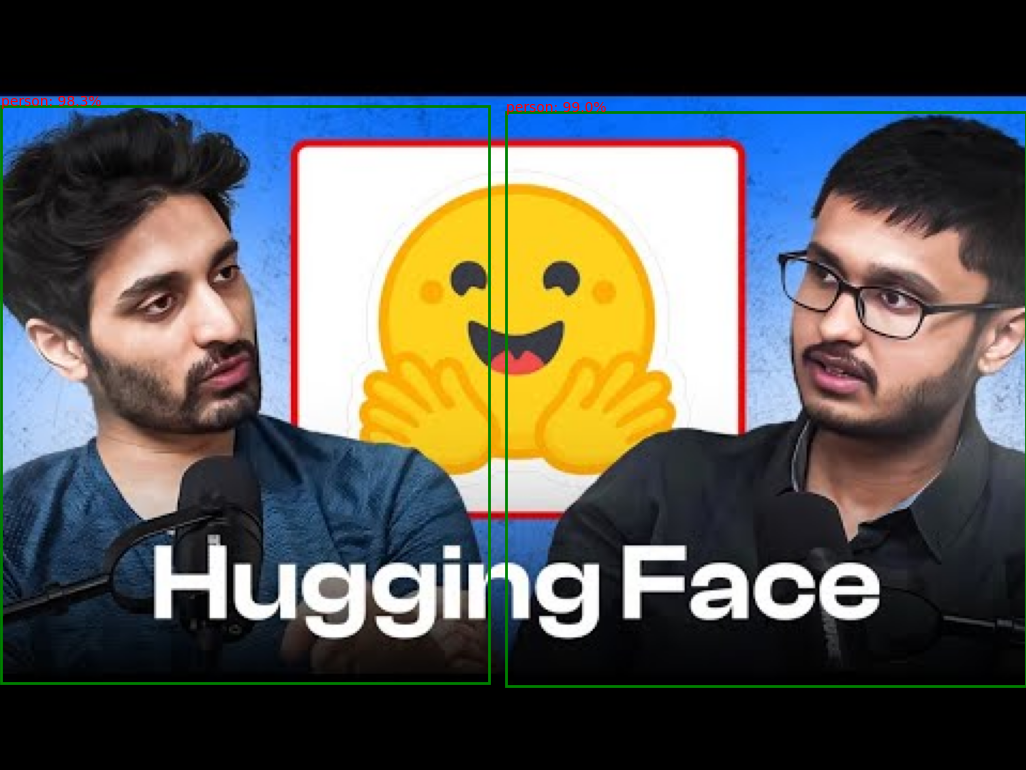

In [9]:
processed_image

In [ ]:
import os
import gradio as gr

In [ ]:
def get_pipeline_prediction(pil_image):

    pipeline_output = od_pipe(pil_image)

    processed_image = render_results_in_image(pil_image,
                                            pipeline_output)
    return processed_image

In [ ]:
demo = gr.Interface(
  fn=get_pipeline_prediction,
  inputs=gr.Image(label="Input image",
                  type="pil"),
  outputs=gr.Image(label="Output image with predicted instances",
                   type="pil")
)

In [ ]:
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://edf331519ac98b5c19.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
demo.close()

Closing server running on port: 7860


In [ ]:
pipeline_output

[{'score': 0.9831472039222717,
  'label': 'person',
  'box': {'xmin': 0, 'ymin': 49, 'xmax': 228, 'ymax': 319}},
 {'score': 0.9904302954673767,
  'label': 'person',
  'box': {'xmin': 236, 'ymin': 52, 'xmax': 479, 'ymax': 320}}]

In [ ]:
text = summarize_predictions_natural_language(pipeline_output)

In [ ]:
text

'In this image, there are two persons.'

In [ ]:
tts_pipe = pipeline("text-to-speech",
                    model="kakao-enterprise/vits-ljs")